In [318]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm
from copy import deepcopy

from catboost import CatBoostClassifier

## Обработка данных

In [129]:
df = pd.read_csv("titanic.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
for c in df.columns:
    print(c, len(df[c].value_counts()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 88
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 147
Embarked 3


In [52]:
def first_digit(s):
    for i in s:
        if i.isdigit():
            return i
    return "0"

In [314]:
df = pd.read_csv("titanic.csv")
df, df_t = train_test_split(df, test_size=0.1, random_state=123, shuffle=True, stratify=df["Survived"])
df.drop(["PassengerId"], axis=1, inplace=True)

age_mean = np.mean(df["Age"])
df.fillna({"Age": age_mean}, inplace=True)

embarked_mean = df["Embarked"].mode()[0]
df.fillna({"Embarked": embarked_mean}, inplace=True)

cabin_mean = "#0"
df.fillna({"Cabin": cabin_mean}, inplace=True)
df["Sector"] = df["Cabin"].apply(lambda x: x[0])
df["Floor"] = df["Cabin"].apply(first_digit)

# ticket_cnt = df["Ticket"].value_counts()
df.drop("Cabin", axis=1, inplace=True)
# df = df.join(ticket_cnt, on="Ticket")
# df.rename(columns={"count": "TicketNeighbours"}, inplace=True)
df.drop("Ticket", axis=1, inplace=True)

df["Sex"] = df["Sex"].map({"female": 0, "male": 1})

# df["Family"] = df["Name"].apply(lambda x: x.split(",")[0])
# family_cnt = df["Family"].value_counts()
# df = df.join(family_cnt, on="Family")
# df.rename(columns={"count": "FamilyNeighbours"}, inplace=True)
# df.drop("Family", axis=1, inplace=True)

df["Status"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0])
df.drop("Name", axis=1, inplace=True)

cat_features = ["Floor", "Embarked", "Sector", "Status"]
ohe = OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore')
df = df.join(pd.DataFrame(ohe.fit_transform(df[cat_features]), columns=ohe.get_feature_names_out(), index=df.index))
df.drop(cat_features, axis=1, inplace=True)

scaler = StandardScaler()
non_cat = ["Age", "SibSp", "Parch", "Fare"]#, "FamilyNeighbours", "TicketNeighbours"]
scaled = pd.DataFrame(scaler.fit_transform(df[non_cat]), columns=non_cat, index=df.index)
df.drop(non_cat, axis=1, inplace=True)
df = df.join(scaled)

<Axes: >

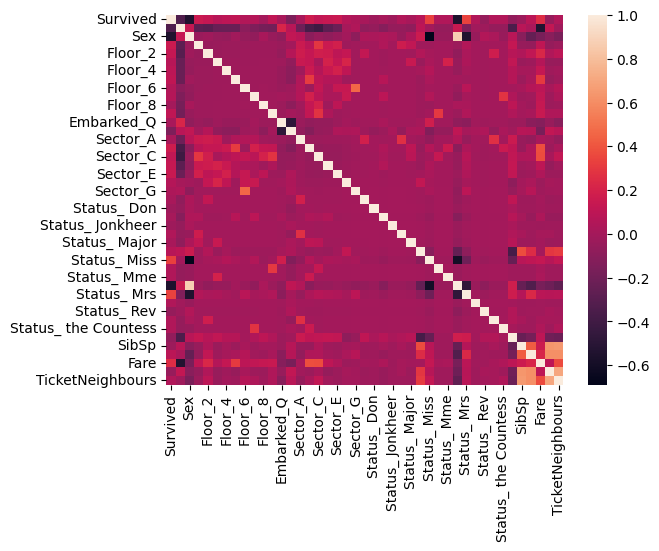

In [207]:
sns.heatmap(df.corr())

In [183]:
lst = []
for col in df.columns:
    lst.append((abs(np.corrcoef(df["Survived"], df[col])[0][1]), col))
sorted(lst, reverse=True)

[(0.9999999999999999, 'Survived'),
 (0.5505114020725417, 'Status_ Mr'),
 (0.5458369324924038, 'Sex'),
 (0.3370476083218818, 'Status_ Mrs'),
 (0.33545421608979303, 'Pclass'),
 (0.33181789584098076, 'Status_ Miss'),
 (0.2528767202680243, 'Fare'),
 (0.16645947142408807, 'Sector_B'),
 (0.15258533003282662, 'Embarked_S'),
 (0.15123687832679286, 'Floor_1'),
 (0.14356034118042574, 'Sector_E'),
 (0.13588614748106195, 'Sector_D'),
 (0.12764752824723571, 'Floor_2'),
 (0.10993417187658797, 'Sector_C'),
 (0.10570427290792565, 'Floor_5'),
 (0.1055560062045598, 'Floor_9'),
 (0.09648340878236737, 'Floor_4'),
 (0.08895670194403588, 'Parch'),
 (0.07602368923884766, 'Status_ Master'),
 (0.07232034469975217, 'Floor_3'),
 (0.0708726008034905, 'Age'),
 (0.06132099643569809, 'Sector_F'),
 (0.06132099643569799, 'Floor_7'),
 (0.055847861535025155, 'Status_ Rev'),
 (0.05330489780625091, 'FamilyNeighbours'),
 (0.05161767146182314, 'Floor_6'),
 (0.046933367722580714, 'TicketNeighbours'),
 (0.04484864157882375, '

In [185]:
np.array(np.where(df.corr().values > 0.9)).T

array([[ 0,  0],
       [ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10],
       [11, 11],
       [12, 12],
       [13, 13],
       [14, 14],
       [15, 15],
       [16, 16],
       [17, 17],
       [18, 18],
       [19, 19],
       [20, 20],
       [21, 21],
       [22, 22],
       [23, 23],
       [24, 24],
       [25, 25],
       [26, 26],
       [27, 27],
       [28, 28],
       [29, 29],
       [30, 30],
       [31, 31],
       [32, 32],
       [33, 33],
       [34, 34],
       [35, 35],
       [36, 36],
       [37, 37],
       [38, 38],
       [39, 39],
       [40, 40],
       [41, 41],
       [42, 42]], dtype=int64)

In [187]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(df.drop("Survived", axis=1), df["Survived"])
sorted(zip(rf.feature_importances_, df.drop("Survived", axis=1).columns), reverse=True)

[(0.18077657035377087, 'Fare'),
 (0.16527286733737837, 'Age'),
 (0.11930928170050752, 'Status_ Mr'),
 (0.10910281782847837, 'Sex'),
 (0.06098096545876615, 'Pclass'),
 (0.050645921250277684, 'FamilyNeighbours'),
 (0.050383159901290456, 'TicketNeighbours'),
 (0.03755195191231171, 'SibSp'),
 (0.03652327631137449, 'Status_ Miss'),
 (0.031769509622534754, 'Status_ Mrs'),
 (0.02381610349307449, 'Parch'),
 (0.02217150064659447, 'Embarked_S'),
 (0.010340759003078312, 'Sector_E'),
 (0.010314972936674927, 'Floor_1'),
 (0.009353487918580287, 'Embarked_Q'),
 (0.008448246906388216, 'Floor_2'),
 (0.008136471421759498, 'Status_ Master'),
 (0.0075563280460828, 'Sector_B'),
 (0.007387903124746512, 'Sector_C'),
 (0.006786559010093193, 'Floor_5'),
 (0.00647536973475272, 'Sector_D'),
 (0.0044709986285370725, 'Floor_4'),
 (0.004335791397476391, 'Floor_3'),
 (0.004146624380189174, 'Floor_9'),
 (0.0037909320576113683, 'Sector_A'),
 (0.003252242490317354, 'Floor_6'),
 (0.0029216880181190566, 'Status_ Rev'),
 

In [206]:
lr = LogisticRegression()
lr.fit(df.drop("Survived", axis=1), df["Survived"])
sorted(zip(abs(lr.coef_.ravel()), df.drop("Survived", axis=1).columns), reverse=True)

[(1.596914511367715, 'Status_ Master'),
 (1.5418463960379267, 'Sex'),
 (1.1333898747518107, 'Status_ Mr'),
 (1.0921181969436002, 'Floor_9'),
 (1.0044616598732417, 'Sector_E'),
 (0.8771428449956356, 'Pclass'),
 (0.8765809623533307, 'Status_ Mrs'),
 (0.787731347801384, 'Floor_1'),
 (0.6920701724342684, 'Status_ Rev'),
 (0.5317940036774398, 'Status_ Don'),
 (0.5199489872300352, 'Sector_F'),
 (0.4924795086294138, 'Floor_5'),
 (0.4773644368025008, 'Sector_D'),
 (0.46184092072329386, 'SibSp'),
 (0.4575147345564563, 'Floor_8'),
 (0.4550507058099886, 'Floor_2'),
 (0.44860482596944873, 'Age'),
 (0.43353736431870077, 'Status_ Jonkheer'),
 (0.43086171548788865, 'Embarked_S'),
 (0.39488564314000085, 'Sector_C'),
 (0.35945854601267174, 'Status_ Sir'),
 (0.33780244045813557, 'Status_ Dr'),
 (0.2291296850433288, 'Status_ Ms'),
 (0.21447156541252096, 'FamilyNeighbours'),
 (0.20351977531989257, 'Floor_3'),
 (0.20104896546915163, 'Fare'),
 (0.15777241696122643, 'Floor_7'),
 (0.14151924496426532, 'Parch'

## Обучение

In [315]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [238]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=2,
    criterion="gini",
    random_state=123
)
cross_val_score(clf, X, y, cv=5, scoring="f1").mean()

0.7488760034565243

In [264]:
clf = CatBoostClassifier(
    verbose=0, 
    random_state=123,
    iterations=1000,
    learning_rate=0.5,
    depth=5
)
cross_val_score(clf, X, y, cv=5, scoring="f1").mean()

0.7658268784719395

In [260]:
clf = RidgeClassifier(alpha=1, random_state=123)
cross_val_score(clf, X, y, cv=5, scoring="f1").mean()

0.7588117394595038

In [255]:
clf = MLPClassifier((10, 100, 10), random_state=123, max_iter=1000)
cross_val_score(clf, X, y, cv=5, scoring="f1").mean()

0.7356054452057899

In [245]:
clf = KNeighborsClassifier(
    n_neighbors=5
)
cross_val_score(clf, X, y, cv=5, scoring="f1").mean()

0.7279296205099705

In [268]:
# Пример кросс-валидации
lst = []
for d in tqdm(range(1, 10)):
    for mss in range(2, 20):
        for c in ["gini", "entropy"]:
            clf = DecisionTreeClassifier(
                max_depth=d,
                min_samples_split=mss,
                criterion=c
            )
            cvs = cross_val_score(clf, X, y, cv=5, scoring="f1").mean()
            lst.append((cvs, d, mss, c))
sorted(lst, reverse=True)

  0%|          | 0/9 [00:00<?, ?it/s]

[(0.7465932630020272, 9, 13, 'entropy'),
 (0.745803161216133, 4, 11, 'gini'),
 (0.745803161216133, 4, 10, 'gini'),
 (0.745803161216133, 4, 9, 'gini'),
 (0.745803161216133, 4, 6, 'gini'),
 (0.745803161216133, 4, 5, 'gini'),
 (0.745803161216133, 4, 4, 'gini'),
 (0.7457907764506315, 4, 11, 'entropy'),
 (0.7457907764506315, 4, 8, 'entropy'),
 (0.7457907764506315, 4, 7, 'entropy'),
 (0.7447006601715617, 4, 13, 'entropy'),
 (0.7447006601715617, 4, 10, 'entropy'),
 (0.7447006601715617, 4, 9, 'entropy'),
 (0.7447006601715617, 4, 6, 'entropy'),
 (0.7447006601715617, 4, 2, 'entropy'),
 (0.7445902579903265, 4, 7, 'gini'),
 (0.744146513458393, 4, 18, 'gini'),
 (0.7436467810862972, 4, 17, 'entropy'),
 (0.7436467810862972, 4, 15, 'entropy'),
 (0.7433654110961883, 4, 14, 'gini'),
 (0.7429654110961883, 4, 19, 'gini'),
 (0.7429654110961883, 4, 16, 'gini'),
 (0.7425566648072274, 4, 16, 'entropy'),
 (0.7418605088863839, 4, 12, 'gini'),
 (0.7418605088863839, 4, 8, 'gini'),
 (0.7418605088863839, 4, 3, 'gin

In [275]:
lst = []
for c in tqdm(np.linspace(0.0001, 1, 100)):
    for k in ['linear', 'poly', 'rbf', 'sigmoid']:
        clf = svm.SVC(C=c, kernel=k)
        cvs = cross_val_score(clf, X, y, cv=5, scoring="f1").mean()
        lst.append((cvs, c, k))
sorted(lst, reverse=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[(0.7755332717685953, 0.44449999999999995, 'linear'),
 (0.7755332717685953, 0.43439999999999995, 'linear'),
 (0.7754161831788626, 0.5354, 'linear'),
 (0.7754161831788626, 0.5253, 'linear'),
 (0.7741913362847244, 0.5152, 'linear'),
 (0.7741913362847244, 0.5051, 'linear'),
 (0.7741913362847244, 0.495, 'linear'),
 (0.7741913362847244, 0.4849, 'linear'),
 (0.7741913362847244, 0.47479999999999994, 'linear'),
 (0.7741913362847244, 0.46469999999999995, 'linear'),
 (0.7741913362847244, 0.45459999999999995, 'linear'),
 (0.7741703480347224, 0.5556, 'linear'),
 (0.7741703480347224, 0.5455, 'linear'),
 (0.7737249138933893, 0.6364, 'linear'),
 (0.7737249138933893, 0.6263, 'linear'),
 (0.7737249138933893, 0.6162, 'linear'),
 (0.7736449948213098, 0.42429999999999995, 'linear'),
 (0.7729455011405841, 0.6061, 'linear'),
 (0.7729455011405841, 0.596, 'linear'),
 (0.7729455011405841, 0.5859, 'linear'),
 (0.7729455011405841, 0.5758, 'linear'),
 (0.7729455011405841, 0.5657, 'linear'),
 (0.7717257625142325, 

## Проверка на отложенной выборке

In [316]:
df_test = deepcopy(df_t)
df_test.drop(["PassengerId"], axis=1, inplace=True)

df_test.fillna({"Age": age_mean}, inplace=True)
df_test.fillna({"Embarked": embarked_mean}, inplace=True)
df_test.fillna({"Cabin": cabin_mean}, inplace=True)

df_test["Sector"] = df_test["Cabin"].apply(lambda x: x[0])
df_test["Floor"] = df_test["Cabin"].apply(first_digit)

df_test.drop("Cabin", axis=1, inplace=True)
# df_test = df_test.join(ticket_cnt, on="Ticket")
# df_test.rename(columns={"count": "TicketNeighbours"}, inplace=True)
df_test.drop("Ticket", axis=1, inplace=True)

df_test["Sex"] = df_test["Sex"].map({"female": 0, "male": 1})

# df_test["Family"] = df_test["Name"].apply(lambda x: x.split(",")[0])
# df_test = df_test.join(family_cnt, on="Family")
# df_test.rename(columns={"count": "FamilyNeighbours"}, inplace=True)
# df_test.drop("Family", axis=1, inplace=True)

df_test["Status"] = df_test["Name"].apply(lambda x: x.split(",")[1].split(".")[0])
df_test.drop("Name", axis=1, inplace=True)

df_test = df_test.join(pd.DataFrame(ohe.transform(df_test[cat_features]), columns=ohe.get_feature_names_out(), index=df_test.index))
df_test.drop(cat_features, axis=1, inplace=True)

scaled = pd.DataFrame(scaler.transform(df_test[non_cat]), columns=non_cat, index=df_test.index)
df_test.drop(non_cat, axis=1, inplace=True)
df_test = df_test.join(scaled)

C:\Users\User\jupyter\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [319]:
X_test, y_test = df_test.drop(["Survived"], axis=1), df_test["Survived"]
clf = svm.SVC(C=0.44449999999999995, kernel="linear")
clf.fit(X, y)
pred = clf.predict(X_test)
f1_score(pred, y_test)

0.7761194029850746